## Занятие 8. Поиск ключевых точек и сопоставление изображений
#### Часть 3. Сопоставление с помощью нейросетей
**Алгоритм**:

0. Найти ключевые точки (КТ) на R
1. Найти ключевые КТ на Q
2. Сопоставить КТ Q и R друг-другу
3. На основе сопоставления точек найти гомографию из Q в R

Полная аналогия с пайплайном на классическом CV, но вместо классических CV-алгоритмов - нейросети. 
1. Детектор ключевых точек: SIFT -> SuperPoint
2. Матч ключевых точек: KNN -> SuperGlue

## Для работы ноутбука - должен быть склонен SuperGlue

In [ ]:
### 

### 3.1 SuperPoint
[SuperPoint: Self-Supervised Interest Point Detection and Description](https://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w9/DeTone_SuperPoint_Self-Supervised_Interest_CVPR_2018_paper.pdf)


In [1]:
import torch
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

BASE_PATH = Path().absolute()
assert BASE_PATH.name == 'c08'

In [2]:
gpu = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu:0')
gpu = torch.device('cpu:0')

In [3]:
cd SuperGluePretrainedNetwork/

D:\edu\teach\course_cvdl\classes\c08\SuperGluePretrainedNetwork


In [4]:
import matplotlib

_backend = matplotlib.get_backend()

from models.superpoint import SuperPoint
from models.utils import read_image

matplotlib.use(_backend)
%matplotlib inline


In [5]:
spoint = SuperPoint({'keypoint_threshold': 0.05}).to(gpu)

Loaded SuperPoint model


In [6]:
img1, img1_t, _ = read_image(
    BASE_PATH/ 'hpatches_tiny'/'v_bird'/'1.ppm',
    device=gpu,
    resize=(640, 480), 
    rotation=0, 
    resize_float=True
)

img2, img2_t, _ = read_image(
    BASE_PATH/ 'hpatches_tiny'/'v_bird'/'2.ppm',
    device=gpu,
    resize=(640, 480), 
    rotation=0, 
    resize_float=True
)

In [7]:
print(f"N parameters: {sum([p.numel() for p in spoint.parameters()])}")
spoint

N parameters: 1300865


SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(25

In [8]:
kpt1 = spoint({'image': img1_t})
kpt1.keys()

dict_keys(['keypoints', 'scores', 'descriptors'])

In [9]:
kpt1['keypoints'][0].shape, kpt1['scores'][0].shape, kpt1['descriptors'][0].shape

(torch.Size([894, 2]), torch.Size([894]), torch.Size([256, 894]))

Особенности сети
#### Итеративный NMS

In [10]:
def simple_nms(scores, nms_radius: int, iters=2):
    """ Fast Non-maximum suppression to remove nearby points """
    assert(nms_radius >= 0)

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius*2+1, stride=1, padding=nms_radius)

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(iters):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)

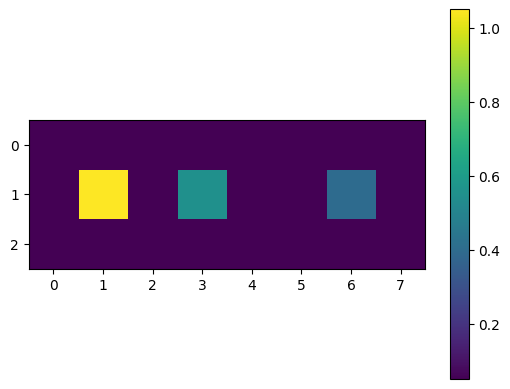

In [11]:
t = torch.tensor([
    [0, 0., 0, 0.0, 0, 0, 0.0, 0],
    [0, 1., 0, 0.5, 0, 0, 0.35, 0],
    [0, 0., 0, 0.0, 0, 0, 0.0, 0]
])[None, None] + 0.05

plt.imshow(t[0,0].numpy())
plt.colorbar()

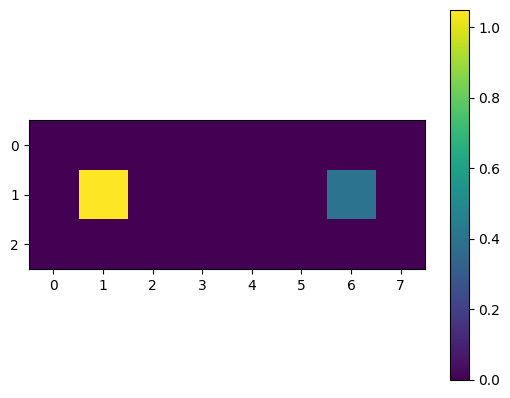

In [12]:
plt.imshow(simple_nms(t, 3, iters=2)[0,0].numpy())
plt.colorbar()

#### PixelShuffle

In [13]:
ps = torch.nn.PixelShuffle(upscale_factor=2)

In [14]:
t = torch.tensor(np.arange(2*2*3*5)).reshape((1, 4, 3, 5))
t[0,3]

tensor([[45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54],
        [55, 56, 57, 58, 59]], dtype=torch.int32)

In [15]:
ps(t)

tensor([[[[ 0, 15,  1, 16,  2, 17,  3, 18,  4, 19],
          [30, 45, 31, 46, 32, 47, 33, 48, 34, 49],
          [ 5, 20,  6, 21,  7, 22,  8, 23,  9, 24],
          [35, 50, 36, 51, 37, 52, 38, 53, 39, 54],
          [10, 25, 11, 26, 12, 27, 13, 28, 14, 29],
          [40, 55, 41, 56, 42, 57, 43, 58, 44, 59]]]], dtype=torch.int32)

### Grid Sample

C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torch\nn\functional.py:4058: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


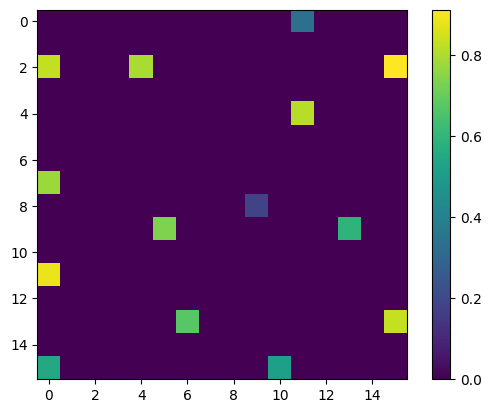

In [16]:
scores = simple_nms(
    torch.nn.functional.upsample_bilinear(torch.rand(1, 1, 8, 8), scale_factor=2),
    3
)
plt.imshow(scores[0, 0])
plt.colorbar()

torch.Size([4])
torch.Size([6, 4, 4])


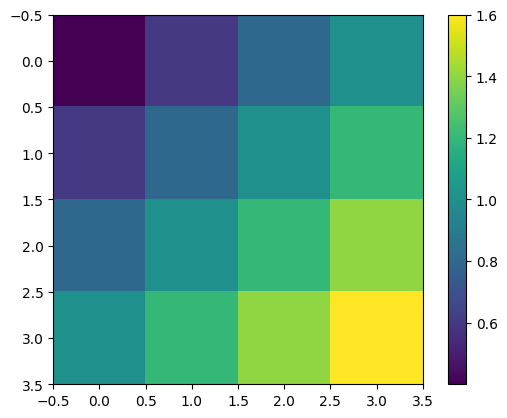

In [17]:
_d = torch.linspace(0.2, 0.8, 4)
print(_d.shape)
descriptors_2d = (_d[None, :, None] + _d[None, None, :]) * torch.ones(6)[:, None, None]
plt.imshow(descriptors_2d[1])
plt.colorbar()
print(descriptors_2d.shape)

In [18]:
keypoints = [torch.nonzero(scores[0] > 0.1)]
keypoints

[tensor([[ 0,  0, 11],
         [ 0,  2,  0],
         [ 0,  2,  4],
         [ 0,  2, 15],
         [ 0,  4, 11],
         [ 0,  7,  0],
         [ 0,  8,  9],
         [ 0,  9,  5],
         [ 0,  9, 13],
         [ 0, 11,  0],
         [ 0, 13,  6],
         [ 0, 13, 15],
         [ 0, 15,  0],
         [ 0, 15, 10]])]

In [19]:
scaled_keypoints = keypoints[0].float() 
scaled_keypoints[:,1:] /= (16 - 1)
scaled_keypoints[:, 1:] -= 0.5
scaled_keypoints[:, 1:] *= 2

scaled_keypoints

tensor([[ 0.0000, -1.0000,  0.4667],
        [ 0.0000, -0.7333, -1.0000],
        [ 0.0000, -0.7333, -0.4667],
        [ 0.0000, -0.7333,  1.0000],
        [ 0.0000, -0.4667,  0.4667],
        [ 0.0000, -0.0667, -1.0000],
        [ 0.0000,  0.0667,  0.2000],
        [ 0.0000,  0.2000, -0.3333],
        [ 0.0000,  0.2000,  0.7333],
        [ 0.0000,  0.4667, -1.0000],
        [ 0.0000,  0.7333, -0.2000],
        [ 0.0000,  0.7333,  1.0000],
        [ 0.0000,  1.0000, -1.0000],
        [ 0.0000,  1.0000,  0.3333]])

In [20]:
print(descriptors_2d.shape)

torch.Size([6, 4, 4])


In [21]:
descriptors = torch.nn.functional.grid_sample(
        descriptors_2d[None], scaled_keypoints.reshape(1, 1, -1, 2), mode='bilinear'
)

C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [22]:
descriptors[0, :, 0, 0 ]

tensor([0.3500, 0.3500, 0.3500, 0.3500, 0.3500, 0.3500])

### 3.2 SuperGlue
[SuperGlue: Learning Feature Matching With Graph Neural Networks](https://openaccess.thecvf.com/content_CVPR_2020/papers/Sarlin_SuperGlue_Learning_Feature_Matching_With_Graph_Neural_Networks_CVPR_2020_paper.pdf)


In [23]:
from models.superglue import SuperGlue

In [60]:
sglue = SuperGlue(config={'match_threshold': 0.5}).to(gpu)
print(f"N parameters: {sum([p.numel() for p in sglue.parameters()])}")


Loaded SuperGlue model ("indoor" weights)
N parameters: 12023297


In [61]:
kpt1 = spoint({'image': img1_t})
kpt2 = spoint({'image': img2_t})


In [62]:
sg_input = dict()
for (k, v) in kpt1.items():
    sg_input[k + '0'] = torch.stack(v, axis=0).to(gpu)

for (k, v) in kpt2.items():
    sg_input[k + '1'] = torch.stack(v, axis=0).to(gpu)
    
sg_input['image0'] = img1_t
sg_input['image1'] = img2_t

In [63]:
with torch.no_grad():
    sg_output = sglue(sg_input)
sg_output.keys()

dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1'])

In [ ]:
sg_output['matches0']

In [ ]:
sg_output['matching_scores0']

In [66]:
def extract_matched_keypoints(sg_in, sg_out):
    idx0 = sg_out['matches0'] > -1
    kpts0 = sg_in['keypoints0'][0][idx0[0]]
    idx1 = sg_out['matches0'][idx0]
    kpts1 = sg_in['keypoints1'][0][idx1]
    return kpts0, kpts1

kp_matched0, kp_matched1 = extract_matched_keypoints(sg_input, sg_output)
kp_matched0.shape, kp_matched1.shape

(torch.Size([355, 2]), torch.Size([355, 2]))

In [67]:
import matplotlib.cm as cm
from models.utils import make_matching_plot, make_matching_plot_fast

def show_results(sg_in, sg_out):
    img0 = sg_in['image0'].numpy().squeeze()
    img1 = sg_in['image1'].numpy().squeeze()
    
    kpts0 = sg_in['keypoints0'][0].cpu().numpy()
    kpts1 = sg_in['keypoints1'][0].cpu().numpy()
    matches = sg_out['matches0'][0].cpu().numpy()
    confidence = sg_out['matching_scores0'][0].cpu().numpy()
    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    color = cm.jet(confidence[valid])

    out = make_matching_plot_fast(
            img0, img1, kpts0, kpts1, mkpts0, mkpts1, color, "",
            path=None, show_keypoints=True, small_text=""
    )
    return out



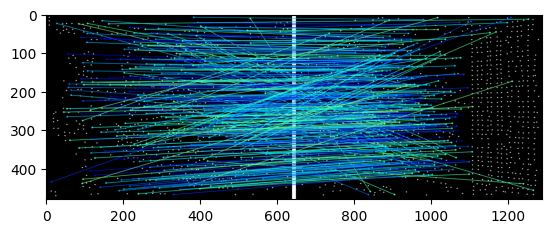

In [68]:
plt.imshow(show_results(sg_input, sg_output))

### 3.3 Sinkhorn Iterations
https://openaccess.thecvf.com/content/CVPR2022/papers/Eisenberger_A_Unified_Framework_for_Implicit_Sinkhorn_Differentiation_CVPR_2022_paper.pdf

In [71]:
from models.superglue import log_optimal_transport

In [86]:
t = (torch.randn((1, 4, 6)) - 0.5) * 5
t

tensor([[[ -4.6053,   2.3745,  -4.7579,   1.4227,  -2.1625,  -0.4598],
         [ -0.6827,  -0.5426, -13.3351,   2.3925, -15.0390,  -6.8371],
         [  3.0143,  -0.7197,  -8.9032,  -6.1131,  -3.9323,   2.4756],
         [ -0.6710,  -4.9953,  -8.0005,  -0.9235,  -4.3601,  -4.5880]]])

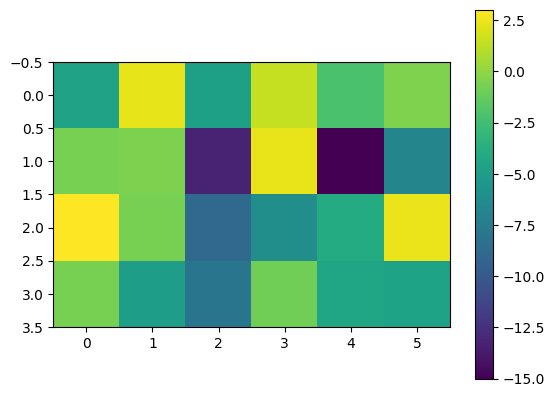

In [97]:
plt.imshow(t[0])
plt.colorbar()

In [98]:
alpha = torch.Tensor([0.0042])

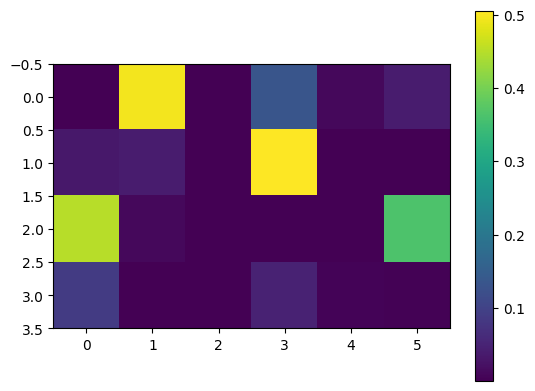

In [101]:
plt.imshow(torch.exp(log_optimal_transport(t, alpha, 2))[0, :-1, :-1])
plt.colorbar()

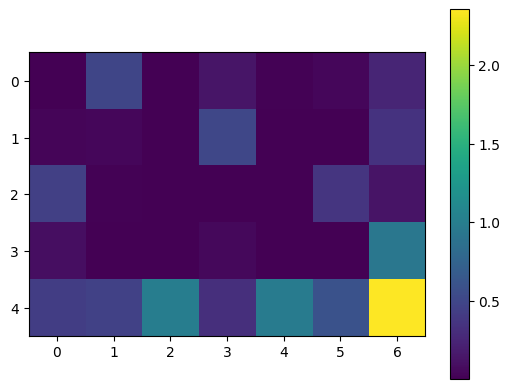

In [103]:
plt.imshow(torch.exp(log_optimal_transport(t, alpha, 2))[0])
plt.colorbar()

In [104]:
# сумма по 1 оси
# Сумма dustbin = N
torch.exp( # Матрица возводится в экспоненту!
    log_optimal_transport(t, alpha, 2)
).numpy().round(2).sum(axis=1)

array([[1.  , 1.  , 1.  , 0.99, 0.99, 1.  , 4.  ]], dtype=float32)

In [106]:
# сумма по 2 оси
# Сумма dustbin = M
(torch.exp(log_optimal_transport(t, alpha, 2))).numpy().round(2).sum(axis=2)

array([[0.92      , 0.91999996, 0.94      , 1.08      , 6.12      ]],
      dtype=float32)

In [108]:
# Сумма всей матрицы
# M + N
(torch.exp(log_optimal_transport(t, alpha, 2))).numpy().round(2).sum()

9.98

In [110]:
# Результаты при 1 итерации
torch.exp(log_optimal_transport(t, alpha, 1)).numpy().round(2)

array([[[0.  , 0.41, 0.  , 0.12, 0.01, 0.03, 0.16],
        [0.02, 0.03, 0.  , 0.39, 0.  , 0.  , 0.2 ],
        [0.34, 0.01, 0.  , 0.  , 0.  , 0.28, 0.08],
        [0.15, 0.  , 0.  , 0.1 , 0.01, 0.  , 1.34],
        [0.49, 0.55, 1.  , 0.4 , 0.98, 0.68, 2.22]]], dtype=float32)

In [111]:
# Результаты при 3 итерациях (разница большая с iters=1)
torch.exp(log_optimal_transport(t, alpha, 3)).numpy().round(2)

array([[[0.  , 0.52, 0.  , 0.14, 0.01, 0.04, 0.27],
        [0.03, 0.04, 0.  , 0.52, 0.  , 0.  , 0.38],
        [0.47, 0.01, 0.  , 0.  , 0.  , 0.38, 0.13],
        [0.08, 0.  , 0.  , 0.04, 0.  , 0.  , 0.88],
        [0.42, 0.43, 1.  , 0.29, 0.98, 0.58, 2.34]]], dtype=float32)

In [112]:
# Результаты при 10 итерациях (разница не оч большая с iters=3)
torch.exp(log_optimal_transport(t, alpha, 10)).numpy().round(2)

array([[[0.  , 0.53, 0.  , 0.14, 0.01, 0.04, 0.27],
        [0.04, 0.04, 0.  , 0.53, 0.  , 0.  , 0.39],
        [0.47, 0.01, 0.  , 0.  , 0.  , 0.38, 0.13],
        [0.08, 0.  , 0.  , 0.04, 0.  , 0.  , 0.87],
        [0.41, 0.42, 1.  , 0.29, 0.98, 0.57, 2.33]]], dtype=float32)

### Задача-3. Используя cv2.findHomography и нейросети, напишите пайплайн нейронного матчинга

In [121]:
import cv2
SGLUE = sglue
SPOINT = spoint

In [130]:
def neural_matching_pipeline(img_Q_tensor, img_R_tensor):
    """
    Находит отображение Query в Reference, применяет его к изображению
    """
    return cv2.warpPerspective(img_Q_tensor.numpy()[0, 0], P, dsize=(img_R_tensor.shape[-1], img_R_tensor.shape[-2]))


torch.Size([1, 1, 480, 640])


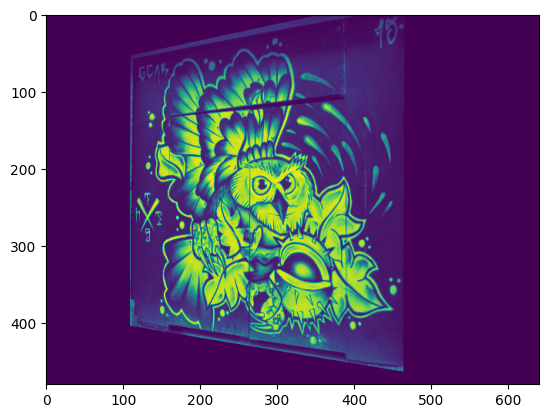

In [136]:
plt.imshow(neural_matching_pipeline(img1_t, img2_t))

torch.Size([1, 1, 480, 640])


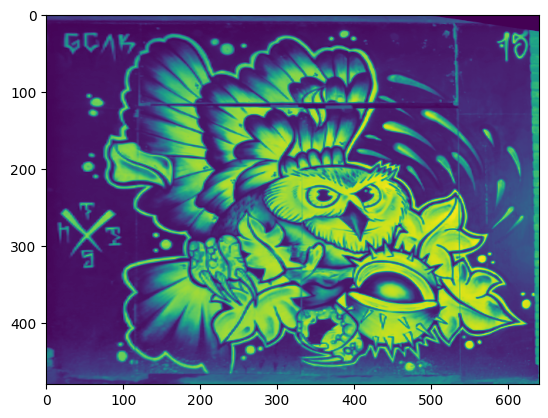

In [137]:
plt.imshow(neural_matching_pipeline(img2_t, img1_t))

### Сравнение результатов разных методов

[Image Matching Across Wide Baselines: From Paper to Practice](https://arxiv.org/pdf/2003.01587.pdf)